# Kernel Methods using the Dual Perceptron and Support Vector Machine

<Intro/Preamble Here>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We know that the XOR function for two binary variables produces a non-linearly separable dataset.

As shown below:

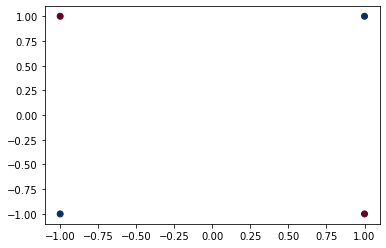

In [2]:
X = np.array([[1,-1,-1],
             [1,-1,1],
             [1,1,-1],
             [1,1,1]])
y = np.array([1, -1, -1, 1])

plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.RdBu)

This data is therefore impossible to learn with a linear classifier, like the *primal* (non-kernel) perceptron. 

However, we can use the *kernel* perceptron (derived from the dual perceptron) to learn this non-linear relationship.

## The Dual Perceptron

The dual perceptron learns parameters $\alpha_i$ for each point ($i=1, \cdots n$), where $n$ is the size of the dataset. The individual $\alpha_i$ represents the number of times the perceptron makes a mistake on a point with index $i$. The algorithm is defined as follows:

\begin{align*}
&\text{input: } (x_1,y_1),\dots, (x_n, y_n)\\
&\text{initialise: } w^{(0)} = (0,0,\dots, 0) \in \mathbb{R}^p\\
&\text{for } t=1,\dots, \texttt{max_iter}\\
&\qquad \text{for } i=1, \cdots, N: \\
&\qquad \qquad \text{if } y_i \sum_{j=1}^N \alpha_j y_j \langle x_i, x_j \rangle \le 0:\\
&\qquad \qquad \quad  \alpha_i = \alpha_i + 1\\
\end{align*}

Also notice that we calculate the pairwise dot product $x_i \cdot x_j$ redundantly for every point. To speed this up, we precalculate these values in a **Gram matrix** and reference them later. For a data set $X$, the **Gram matrix** ($G = X^T X$) is defined as:

\begin{align*}
  G &= \begin{bmatrix}
        \langle x_{1}, x_{1} \rangle & \langle x_{1}, x_{2}\rangle &  \cdots & \langle x_{1}, x_{n} \rangle \\
        \langle x_{2}, x_{1} \rangle & \langle x_{2}, x_{2}\rangle & \cdots & \langle x_{2}, x_{n} \rangle \\
        \vdots & \vdots & \ddots & \vdots  \\
        \langle x_{n}, x_{1} \rangle & \langle x_{n}, x_{2}\rangle &  \cdots & \langle x_{n}, x_{n} \rangle \\
      \end{bmatrix} \\
  G_{i,j} &= \langle x_{i}, x_{j} \rangle
\end{align*}

We can then rewrite the dual perceptron using the Gram matrix, instead of calculating dot products at every step:
\begin{align*}
&\text{input: } (x_1,y_1),\dots, (x_n, y_n)\\
&\text{initialise: } w^{(0)} = (0,0,\dots, 0) \in \mathbb{R}^p\\
&\text{for } t=1,\dots, \texttt{max_iter}\\
&\qquad \text{for } i=1, \cdots, N: \\
&\qquad \qquad \text{if } y_i \sum_{j=1}^N \alpha_j y_j G_{i,j} \le 0:\\
&\qquad \qquad \quad  \alpha_i = \alpha_i + 1\\
\end{align*}


## Transformations

To *make* our data linearly separable, we can define a transformation $\phi(x): \mathbb{R}^p \to \mathbb{R}^k$ to project our data from the original $p$ dimensional space to a $k > p$ dimensional space.

**Example**:

For the XOR data, we can choose the following transformation:
\begin{align*}
  \phi(\mathbf{x}) = \begin{bmatrix} 1 \\ \sqrt{2} x_{1} \\ \sqrt{2} x_{2} \\ x_{1}^{2} \\ x_{2}^{2} \\ \sqrt{2} x_{1}x_{2} \end{bmatrix}
\end{align*}

this may seem arbitrary, though this choice of transformation will become clear later.

<font color='purple'>
    
#### Exercise: 
Define the above transformation $\phi(x)$ in code below and plot the 2nd and 6th columns of the transformed dataset. *What do you notice here?*

In [3]:
def phi(X):
    return np.c_[np.ones(X.shape[0]),
            np.sqrt(2) * X[:, 1], 
            np.sqrt(2) * X[:, 2],
            X[:, 1]**2,
            X[:, 2]**2,
            np.sqrt(2) * X[:, 1] * X[:, 2]]

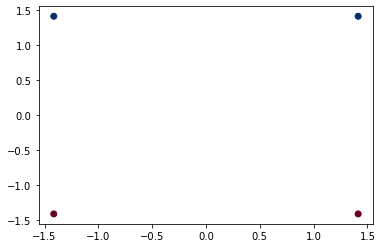

In [4]:
p_X = phi(X)
plt.scatter(p_X[:, 1], p_X[:, 5], c=y, cmap=plt.cm.RdBu)

## The Kernel Trick

In this transformed space, our Gram matrix is now defined as:

\begin{align*}
  G &= \begin{bmatrix}
        \langle \phi(x_{1}), \phi(x_{1}) \rangle & \langle \phi(x_{1}), \phi(x_{2})\rangle &  \cdots & \langle \phi(x_{1}), x_{n} \rangle \\
        \langle \phi(x_{2}), \phi(x_{1}) \rangle & \langle \phi(x_{2}), \phi(x_{2})\rangle & \cdots & \langle \phi(x_{2}), \phi(x_{n}) \rangle \\
        \vdots & \vdots & \ddots & \vdots  \\
        \langle \phi(x_{n}), \phi(x_{1}) \rangle & \langle \phi(x_{n}), \phi(x_{2})\rangle & \cdots & \langle \phi(x_{n}), \phi(x_{n}) \rangle \\
      \end{bmatrix} \\
\end{align*}

If we have a transformation $\phi(\mathbf{x}): \mathbb{R}^p \to \mathbb{R}^k$, this matrix becomes increasingly more expensive to calculate as we consider larger $k$.

Recall the transformation used in the XOR example. If we calculate the inner product of two points using this transform, we get

\begin{align*}
    \langle \phi(\mathbf{x}), \phi(\mathbf{y}) \rangle &= \begin{bmatrix} 1 \\ \sqrt{2} x_{1} \\ \sqrt{2} x_{2} \\ x_{1}^{2} \\ x_{2}^{2} \\ \sqrt{2} x_{1}x_{2} \end{bmatrix} \cdot \begin{bmatrix} 1 \\ \sqrt{2} y_{1} \\ \sqrt{2} y_{2} \\ y_{1}^{2} \\ y_{2}^{2} \\ \sqrt{2} y_{1}y_{2} \end{bmatrix}\\
    &= 1 + 2x_{1} y_{1} + 2 x_{2} y_{2} + x_{1}^{2} y_{1}^{2} + x_{2}^{2} y_{2}^{2} + 2 x_{1} x_{2} y_{1} y_{2}\\
    &= 1 + 2(x_{1} y_{1} + x_{2} y_{2}) + (x_{1} y_{1} + x_{2} y_{2})^{2}\\
    &= (1 + \mathbf{x} \cdot \mathbf{y})^2
\end{align*}

We can therefore represent the inner product of two points as:
\begin{align*}
k(\mathbf{x}, \mathbf{y}) &= \langle \phi(\mathbf{x}), \phi(\mathbf{y}) \rangle\\
k(\mathbf{x}, \mathbf{y}) &= (1 + \mathbf{x} \cdot \mathbf{y})^{2}\\
\end{align*}

Therefore, we can redfine the Gram matrix as:
\begin{align*}
  G &= \begin{bmatrix}
        k(x_{1}, x_{1}) &  k(x_{1}, x_{2})&  \cdots &  k(x_{1}, x_{n}) \\
        k(x_{2}, x_{1}) &  k(x_{2}, x_{2})&  \cdots &  k(x_{2}, x_{n}) \\
        \vdots & \vdots & \ddots & \vdots  \\
        k(x_{n}, x_{1}) &  k(x_{n}, x_{2}) &  \cdots &  k(x_{n}, x_{n}) \\
      \end{bmatrix} \\
\end{align*}

This means that we reduce the amount of calculation needed to project the data to a higher dimension, as we simply need to calculate $\langle x, y \rangle$ where $x, y \in \mathbb{R}^p$ to retrieve the projected Gram matrix, rather than $\langle \phi(x), \phi(y) \rangle$ where $\phi(x), \phi(y) \in \mathbb{R}^k$ and $p << k$.

So, if we define a kernel $k(x, y): \mathbb{R}^p \times \mathbb{R}^p \to \mathbb{R}$ which can be represented by basis transformations $k(x, y) = \langle \phi(x), \phi(y) \rangle$, we can use this kernel to redefine the Gram matrix. We can then use this new Gram matrix in our algorithm to work with a projection of the original data. 

<font color='purple'>
    
#### Exercise: 
    
The **kernel perceptron** is essentially the dual perceptron, though we redefine the Gram matrix to store the pairwise inner products the points in the *projected* dataset, where these inner products are represented by a kernel.    

Implement the kernel perceptron in the stub class `KernelPerceptron`. This class should take a generic kernel and kernel arguments as a dictionary.
    
You can use the `**` operator on a Python dictionary to unpack it and pass its key-value pairs as keyword arguments.
    
eg.
    If we have `args = {"c": 100}`, then `f1(**args)` is equivalent to `f1(c=100)`.

In [5]:
class KernelPerceptron():
    def __init__(self, kernel, kernel_args={}):
        self.gram = None
        self.alphas = None
        self.kernel = kernel
        self.kernel_args = kernel_args
        
    def fit(self, X, y, max_iter=100):
        self.gram = self.kernel(X, X, **self.kernel_args)
        self.alphas = np.zeros(X.shape[0])
        self.X = X
        self.y = y
        
        for _ in range(max_iter):
            for i, x_i in enumerate(X):
                y_hat = np.sign(np.sum(self.alphas * self.y * self.gram[:, i]))
                
                if y_hat != self.y[i]:
                    self.alphas[i] += 1
                    
    def decision_function(self, X_prime):
        return self.alphas * self.y @ self.kernel(self.X, X_prime, **self.kernel_args)
    
    def predict(self, X_prime):
        return np.sign(self.decision_function(X_prime))


We define the polynomial kernel as:
\begin{align*}
    k(\mathbf{x}, \mathbf{y}) = (1 + \mathbf{x} \cdot \mathbf{y})^d
\end{align*}

for a degree parameter $d \in \mathbf{R}$.

<font color='purple'>
    
#### Exercise: 

Define the polynomial kernel as a function with signature `polynomial_kernel(x, y, d=2)`.

In [6]:
def polynomial_kernel(x, y, d=2):
    if x.shape[1] == y.shape[1]:
        y = y.T
        
    return (1 + x@y)**d

In [7]:
def plot_decision_boundary(X, y, clf, ax, bias=True, weighted=False, cmap=plt.cm.RdBu):
    idxs = [0, 1]
    if bias == True:
        idxs = [1, 2]
        
    x_min, x_max = X[:, idxs[0]].min() - 1, X[:, idxs[0]].max() + 1
    y_min, y_max = X[:, idxs[1]].min() - 1, X[:, idxs[1]].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x_p = np.c_[xx.ravel(), yy.ravel()]
    if bias == True:
        biases = np.ones(xx.ravel().shape[0])
        x_p = np.c_[biases.ravel(), xx.ravel(), yy.ravel()]
        
    if weighted:
        z = clf.decision_function(x_p)
    else:
        z = clf.predict(x_p)
        
    z = z.reshape(xx.shape)
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.8)
    ax.scatter(X[:, idxs[0]], X[:, idxs[1]], c=y, cmap=cmap)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xx.min(), xx.max())

<font color='purple'>
    
#### Exercise: 

Use the `polynomial_kernel` with the `KernelPerceptron` class to classify the XOR data given and plot the result using `plot_decision_boundary`.

In [8]:
kp = KernelPerceptron(polynomial_kernel, kernel_args={"d": 2})
kp.fit(X, y)

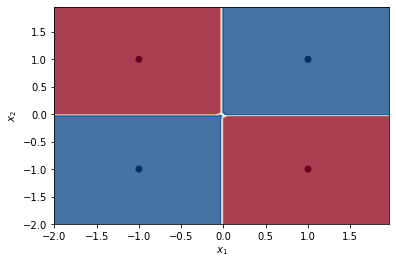

In [9]:
plot_decision_boundary(X, y, kp, plt.subplot(111))

Now, let's apply the Kernel perceptron to a more complex dataset with a non-linear relationship.

For this, we can use the `sklearn` function `make_moons` which generates data from two interleaving half-circles. This function also allows us to add noise and generate a more complex dataset. 

In [10]:
from sklearn.datasets import make_moons

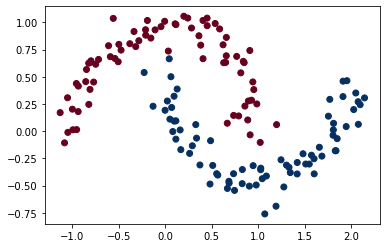

In [11]:
X, y = make_moons(n_samples=150, noise=0.1, random_state=0)
plt.scatter(*X.T, c=y, cmap=plt.cm.RdBu)

<font color='purple'>
    
#### Exercise: 
  
Use data similar to above i.e `X, y = make_moons(n_samples=150, noise=0.1, random_state=0)` and plot the fit of your Kernel perceptron with the polynomial kernel for degrees 1 to 4 inclusive.
    
**Hint:** You should see the Kernel perceptron fitting a convincing boundary for degrees 3 and 4. If you're running into issues, pay attention to the encoding of the *labels* (i.e `y`).

In [12]:
X, y = make_moons(n_samples=150, noise=0.1, random_state=0)
y[np.where(y==0)] = -1
X = np.c_[np.ones(X.shape[0]), X]

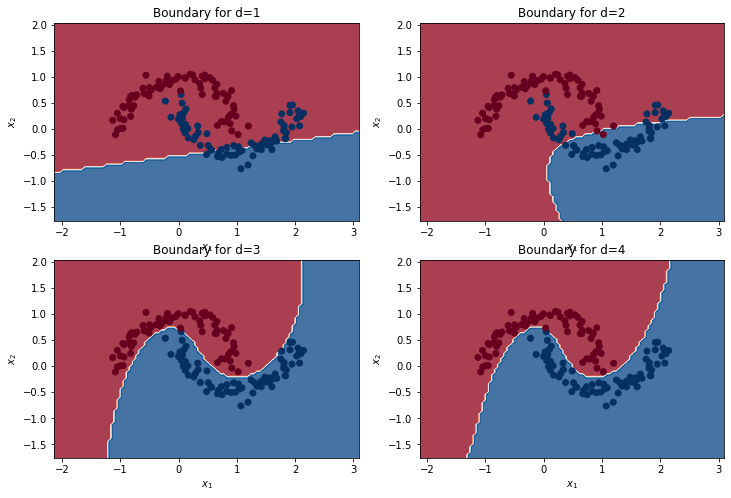

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
d_grid = np.arange(1, 5)
for i, ax in enumerate(axs.flat):
    kp = KernelPerceptron(polynomial_kernel, kernel_args={"d": d_grid[i]})
    kp.fit(X, y)
    plot_decision_boundary(X, y, kp, ax)
    ax.set_title(f"Boundary for d={d_grid[i]}")

## *Extension*: The RBF (Radial Basis Function) Kernel

One of the most powerful and commonly used kernels is the **RBF** kernel, defined by:
\begin{align*}
    k(\mathbf{x}, \mathbf{y}) = \exp \left( -\frac{||\mathbf{x} - \mathbf{y}||^2}{2\sigma^2} \right)
\end{align*}
where $\sigma^2$ is an adjustable hyperparameter.

If we let $\gamma = \frac{1}{2\sigma^2}$, we can rewrite the kernel as:
\begin{align*}
    k(\mathbf{x}, \mathbf{y}) = \exp \left( -\gamma ||\mathbf{x} - \mathbf{y}||^2 \right)
\end{align*}

#### Quantifying the Transformation

Recall a kernel represents the inner product of basis transformations $\phi: \mathbb{R}^p \to \mathbb{R}^k$:
\begin{align*}
k(\mathbf{x}, \mathbf{y}) &= \langle \phi(\mathbf{x}), \phi(\mathbf{y}) \rangle
\end{align*}

So, we can 'deconstruct' a kernel and find its basis transforms, retrieving information to what dimension our data is projected to (i.e $k$).

An exercise for this is in the tutorial, though we can show that for scalar values the RBF is made up of transformations:

\begin{align*}
  \phi(x) &= \exp\left(-\frac{x^{2}}{2 \sigma^{2}}\right)\sum_{i=1}^{\infty}\frac{x^{k}}{\sigma^{k}\sqrt{k!}} \\
\end{align*}

a similar (albeit much more complex) result can be derived for vector values.

Our result shows that the underlying $\phi$ which makes up the RBF kernel projects data to *infinite* dimensions. This is mainly why the RBF is so popular in algorithms which use kernel methods, as it provides theoretically infinite information.

<font color='purple'>
    
#### Exercise: 
 
Implement the `rbf_kernel` function below.
    
**Hint**: Use `pairwise_distances` from `sklearn.metrics` to calculate the pairwise distances necessary for the RBF kernel. Choose the arguments which best model the Euclidean norm used in the formula.

In [14]:
from sklearn.metrics import pairwise_distances
def rbf_kernel(x, y, gamma=1):
    return np.exp(-gamma * pairwise_distances(x, y, 'sqeuclidean'))

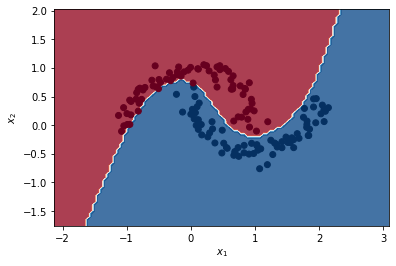

In [15]:
kp = KernelPerceptron(rbf_kernel)
kp.fit(X, y)
plot_decision_boundary(X, y, kp, plt.subplot(111))

<font color='purple'>
    
#### Exercise: 
    
Let's now compare the boundaries of the `polynomial_kernel` and the `rbf_kernel`.
 
Apply the `KernelPerceptron` to the data generated below, with the arguments:
    
- `polynomial_kernel` for $d = 2, 3, 4, 5$
- `rbf_kernel` for $\gamma = 0.1, 0.4, 0.7, 1$

Plot the results on a $2 \times 4$ grid of axes using `plot_decision_boundary` as before. To visualise the *weights* given to points specify the keyword argument `weighted=True`.
    
*What do you think colours in the weighted plot represent?*

In [16]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, centers=[[-1, 0], [1, 1]], random_state=0)
y[np.where(y==0)] = -1
X = np.c_[np.ones(X.shape[0]), X]

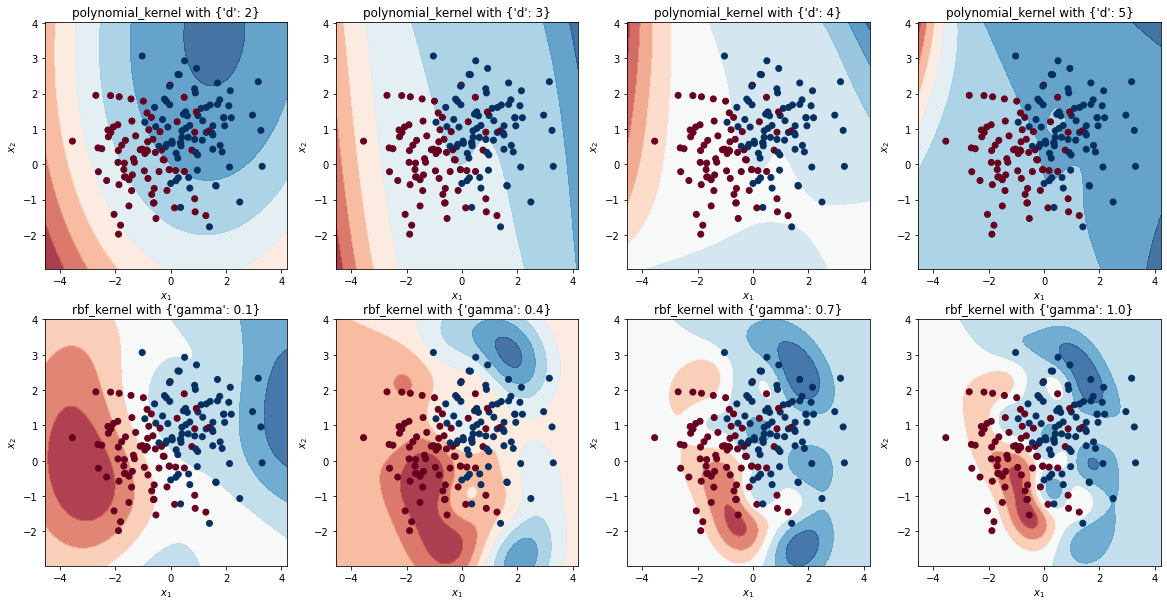

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
kern_grid = { 
    polynomial_kernel: [ {"d": i} for i in range(2, 6) ],
    rbf_kernel: [ {"gamma": i} for i in np.linspace(0.1, 1, 4) ]
}

for i, (kern, args) in enumerate(kern_grid.items()):
    for j, arg in enumerate(args):
        kp = KernelPerceptron(kern, kernel_args=arg)
        kp.fit(X, y)

        plot_decision_boundary(X, y, kp, ax[i, j], weighted=True)
        ax[i,j].set_title(f"{kern.__name__} with {str(arg)}")

## Support Vector Machines

Let's visualise the SVM and its different Kernels.

[SVM-demo](https://jgreitemann.github.io/svm-demo)

<font color='red'>
More on SVMs compared to perceptrons. Define the dual problem, possible discussion on actually solving the problem using SMO as an extension.


In [18]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

In [19]:
X, y = make_blobs(n_samples=100, centers=[[-1, -1], [1, 1]], cluster_std=0.55, random_state=0)

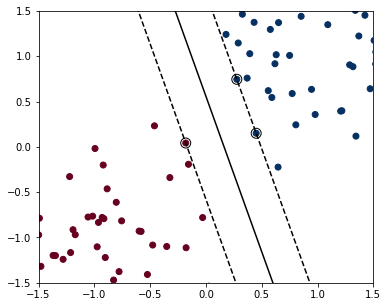

In [20]:
plt.figure(figsize=(6, 5))
clf = SVC(kernel="linear", C=5).fit(X, y)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
yy = a * xx - (clf.intercept_[0]) / w[1]

m = 1/np.linalg.norm(clf.coef_)
lo_support_plane = yy - np.sqrt(1 + a**2) * m
hi_support_plane = yy + np.sqrt(1 + a**2) * m


plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            edgecolors="k", facecolors="none", s=100, cmap=plt.cm.RdBu)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

plt.plot(xx, yy, "k-")
plt.plot(xx, lo_support_plane, "k--")
plt.plot(xx, hi_support_plane, "k--")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

In [21]:
X, y = make_blobs(n_samples=[50, 50, 80], random_state=0)

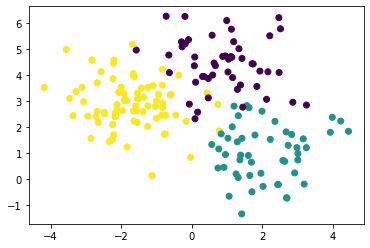

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y)

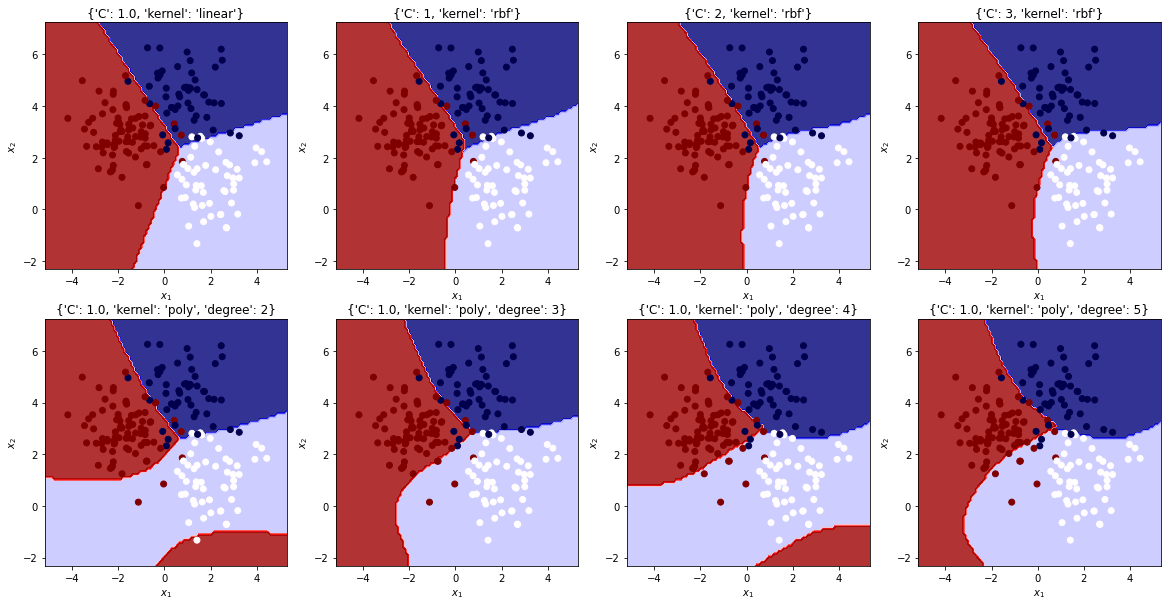

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
arg_grid = [
    {"C": 1.0, "kernel": "linear"},
    *[{"C": i, "kernel": "rbf"} for i in range(1, 4)],
    *[{"C": 1.0, "kernel": "poly", "degree": i} for i in range(2, 6)]
]
for i, (args, ax) in enumerate(zip(arg_grid, axs.flat)):
    clf = SVC(**args).fit(X, y)
    plot_decision_boundary(X, y, clf, ax, bias=False, cmap=plt.cm.seismic)
    ax.set_title(f"{args}")